# TM470 Project - Automating the Identification of UK Coarse Fish

In [1]:
import tensorflow as tf
import kaggle
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit #scikit-learn.org
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as et # https://docs.python.org/3/library/xml.etree.elementtr
from tensorflow.python.client import device_lib #for detection of devices
import glob as glob # Searches for certain files
# for model
import keras
from tensorflow.keras import Sequential, optimizers, metrics, layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
# TensorFlow version
print(tf.__version__)

2.6.0


### 3 Is TF using GPU acceleration from inside python shell.

In [3]:
# Is TF using GPU?
if tf.test.gpu_device_name():
    print('Default GPU device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
# Number of GPU's available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Details of CPU and GPU from the device library (device_lib)
print(device_lib.list_local_devices())

Default GPU device:/device:GPU:0
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12397479842879193615
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6925844480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14632794693513135346
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


### AFFiNe dataset from Kaggle (list, download and unzip)

### Classes taken out of original dataset
Aspius aspius Asp, Carassius gibelio (Carp Prussian), Lepomis gibbosus Pumpkinseed, Neogobius fluviatilis Goby (monkey), Neogobius kessleri Goby (bighead), Neogobius melanostomus (Goby Round), Rhodeus amarus Bitterling (European), Vimba vimba Vimba, Leuciscus leuciscus Dace, Gasterosteus aculeatus Stickleback.


In [4]:
# AFFiNe dataset from Kaggle placed in Jupyter folder
# https://www.kaggle.com/datasets/jorritvenema/affine

In [5]:
datasetPath = 'UK_AFFiNe'

In [6]:
datasetPath

'UK_AFFiNe'

In [7]:
# Assigning dataset path to pathlib
dat_dir = pathlib.Path(datasetPath).with_suffix('')
print(dat_dir)

UK_AFFiNe


In [8]:
# Number of images in dataset
image_count = len(list(dat_dir.glob('*/*.jpg'))) # is this how datasetPath should be?
print(image_count)

5962


# Get class names and bound box information from XML files using the parser

In [9]:
# Reading the information in the XML files and extracting names/bounding box info
path = (dat_dir)
filelist = []
list1 = list()
list2 = list()
for root, dirs, files in os.walk(path):
    for file in files:
        if not file.endswith('.xml'):
            continue
        filelist.append(os.path.join(root, file))
for file in filelist:
    root = et.parse(file).getroot() # get the root of the xml
# Get class names
    for className in root.findall('.//object'):
        class_name = className.find('name').text
        data = np.array([class_name])
    list1.append(data)
# Get bounding box information
    for bndBox in root.findall('.//object'):
        bounding_box = bndBox.find('bndbox').text
        xmin = int(bndBox.find('./bndbox/xmin').text)
        ymin = int(bndBox.find('./bndbox/ymin').text)
        xmax = int(bndBox.find('./bndbox/xmax').text)
        ymax = int(bndBox.find('./bndbox/ymax').text)
        data2 = np.array([xmin,ymin,xmax,ymax])
    list2.append(data2)  

In [10]:
print(len(list1))

5962


## Create dataframe (using relative paths, class names and bound box details from XML)

In [11]:
#list(base_dir.glob('*/*.jpg'))
filepaths = list(dat_dir.glob(r'**/*.jpg'))
classnames = list1#list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
boundboxes = list2

filepaths = pd.Series(filepaths, name='Filepath').astype(str)#str
classnames = pd.Series(classnames, name='Class Name')
boundboxes = pd.Series(boundboxes, name='Boundbox')

dataframe1 = pd.concat([filepaths , classnames, boundboxes] , axis=1)
dataframe1

,Filepath,Class Name,Boundbox
0,UK_AFFiNe\Abramis brama\00a7b0d4-8136-44f3-9e0...,[Abramis brama],"[20, 20, 486, 193]"
1,UK_AFFiNe\Abramis brama\017f3e53-e0e2-4f94-a15...,[Abramis brama],"[20, 20, 515, 187]"
2,UK_AFFiNe\Abramis brama\022e3ceb-a8e0-4e77-9b9...,[Abramis brama],"[20, 20, 283, 916]"
3,UK_AFFiNe\Abramis brama\02436d5d-0421-43c4-b9f...,[Abramis brama],"[20, 20, 697, 244]"
4,UK_AFFiNe\Abramis brama\08282fac-ad90-4a9c-802...,[Abramis brama],"[19, 20, 789, 400]"
...,...,...,...
5957,UK_AFFiNe\Tinca tinca\f917c866-9230-4683-a10c-...,[Tinca tinca],"[13, 20, 772, 346]"
5958,UK_AFFiNe\Tinca tinca\f96c7997-7f5d-4128-8940-...,[Tinca tinca],"[20, 20, 725, 365]"
5959,UK_AFFiNe\Tinca tinca\fbd1d021-5b64-42a2-8637-...,[Tinca tinca],"[20, 20, 651, 270]"
5960,UK_AFFiNe\Tinca tinca\fd1a5781-0723-4826-9a19-...,[Tinca tinca],"[20, 20, 641, 269]"


In [12]:
# species counts for each class with UK AFFiNe

dataframe1['Class Name'].value_counts()

[Cyprinus carpio]                589
[Barbus barbus]                  336
[Leuciscus idus]                 334
[Rutilus rutilus]                318
[Tinca tinca]                    316
[Scardinius erythrophthalmus]    311
[Esox lucius]                    311
[Sander lucioperca]              302
[Ctenopharyngodon idella]        293
[Acipenseridae]                  293
[Leuciscus cephalus]             282
[Silurus glanis]                 272
[Abramis brama]                  271
[Salmo trutta subsp. fario]      270
[Anguilla anguilla]              266
[Perca fluviatilis]              248
[Blicca bjoerkna]                244
[Carassius carassius]            242
[Gymnocephalus cernuus]          236
[Gobio gobio]                    228
Name: Class Name, dtype: int64

In [13]:
# Useful information on Kaggle:
# https://www.kaggle.com/code/reighns/augmentations-data-cleaning-and-bounding-boxes (3 May 23)
# Hiding id behing jpg
#dataframe1["Filepath"] = dataframe1["Filepath"].apply(lambda x: str(x) + ".jpg")
#dataframe1

In [14]:
# Assigning dataset path to pathlib
print(dat_dir)

UK_AFFiNe


In [15]:
# Number of images in dataset and dataframe1
image_count = len(list(dat_dir.glob('*/*.jpg')))
image_count_df = len(dataframe1)
print(image_count)
print(image_count_df)

5962
5962


In [16]:
# The above count for the dataframe is +1, not sure why

# Creating the datasets (how to use dataframe1 created above?)

### startified shuffle split
### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [17]:
X = list(dat_dir.glob(r'**/*.jpg'))
y = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], X))

#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.2, random_state=0)
#sss.get_n_splits(X, y)

#print(sss)

#for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#    print(f"Fold {i}:")
#    print(f"  Train: index={train_index}")
#    print(f"  Test:  index={test_index}")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
#X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 x 0.8 0.2"

In [18]:
#print(X_train)

# Creating datasets using image dataset from directory

In [19]:
# Image size
batch_size=32
img_height=256
img_width=256
image_size=(img_height,img_width,3)
num_classes = 20

In [20]:
# Create the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="training",
  seed=123,#none
  shuffle=True,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 5962 files belonging to 20 classes.
Using 4770 files for training.


In [21]:
# Create the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 5962 files belonging to 20 classes.
Using 1192 files for validation.


In [22]:
# Creating test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  #validation_split=0.6,
  #subset="validation",
  #seed='123',
  shuffle = True,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 5962 files belonging to 20 classes.


In [23]:
# Assign the class names
class_names = test_dataset.class_names#test_dataset
#class_names=list1
print(class_names) 

['Abramis brama', 'Acipenseridae', 'Anguilla anguilla', 'Barbus barbus', 'Blicca bjoerkna', 'Carassius carassius', 'Ctenopharyngodon idella', 'Cyprinus carpio', 'Esox lucius', 'Gobio gobio', 'Gymnocephalus cernuus', 'Leuciscus cephalus', 'Leuciscus idus', 'Perca fluviatilis', 'Rutilus rutilus', 'Salmo trutta subsp. fario', 'Sander lucioperca', 'Scardinius erythrophthalmus', 'Silurus glanis', 'Tinca tinca']


In [24]:
# Next two cells for testing
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape

((32, 256, 256, 3), (32,))

In [25]:
#sample_image_boxed = sample_imgs.copy()
#img_bbox = ImageDraw.Draw(sample_image_boxed)
#for i in range(5):
#print(boundBoxList[0])
#img_bbox.rectangle(boundBoxList[0], outline="green")
#sample_image_boxed

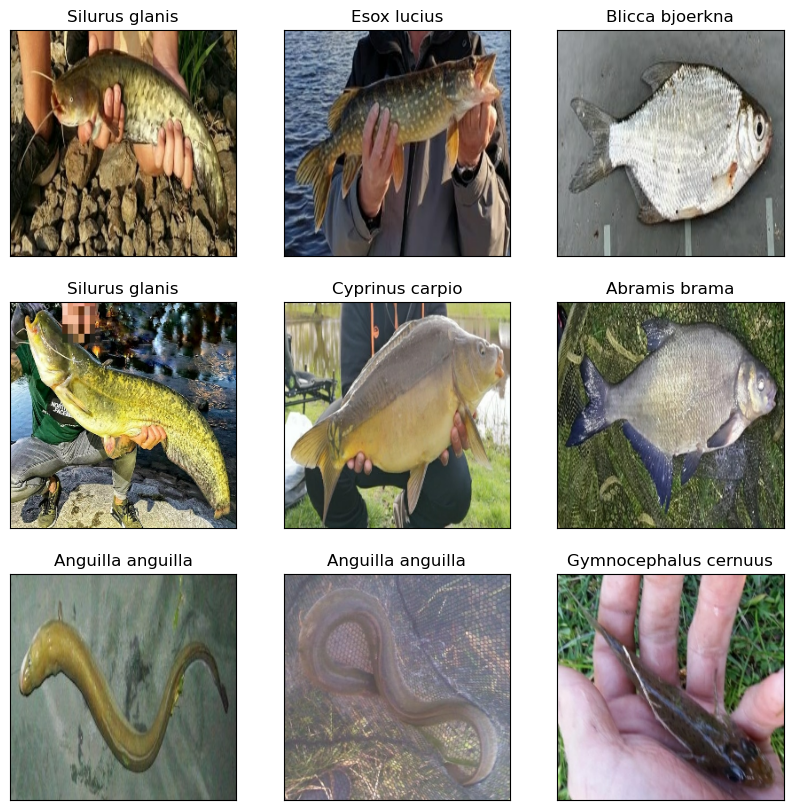

In [26]:
# testing using sample label - to try debug final evaluation
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_imgs[i].astype("uint8")) #images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[sample_labels[i]])
plt.show()

### Checking noise in data

In [27]:
#plt.plot(X.values, list1, linewidth=2, linestyle="-", c="b")#plt.plot(X, y, linewidth=2, linestyle="-", c="b")
#plt.show()
#plt.close()

## My model (based on TM358 EMA model)

### Data augmentation

In [28]:
# Creating the normalisation layer
norm_layer = layers.Normalization(input_shape=(image_size))
norm_layer.adapt(train_dataset.map(lambda x, y: x))

In [29]:
# Creating an augmented subset
data_augmentation = tf.keras.Sequential([
layers.RandomRotation(0.1),#- worse accuracy (but what about overfitting?) causes freezing at 0.1+
layers.RandomZoom(height_factor=0.2),
layers.RandomFlip(mode='horizontal'),
layers.RandomFlip(mode='vertical'),# worse but not having it results in overfitting
])

aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
num_parallel_calls=tf.data.AUTOTUNE)
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model creation

### Train the model

### Evaluating the model (based on code from TM358)

# Testing another model (Based on VGG-16)

In [30]:
ada = tf.keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0001,or 3e-4
def build_model():
      model = Sequential([
          #norm_layer, 
          Conv2D(filters=64, kernel_size=(3,3), padding="same", input_shape=(image_size), activation= "relu"), 
          Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
          #Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),#
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          #Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),#
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          #Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),#
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.5),
          Flatten(),
          #Dense(512, activation='relu'),
          Dense(512, activation='relu'),# num_classes*25 = 500
          Dropout(0.5),
          Dense(num_classes, activation='softmax')#num_classes * 1.5 or 20 * 1. 
      ])
      model.compile(
          optimizer=ada,#'adam',#learning_rate=0.0001,or 3e-4
          loss='sparse_categorical_crossentropy',#sparse_categorical_crossentropy
          metrics=['accuracy']
          )
      return model 

In [31]:
# Build the model using the build_model function
model=build_model()

In [32]:
# Show a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)      

In [33]:
# Train the model
#with tf.device("/cpu:0"):
#with tf.device("/device:GPU:0"):
hist=model.fit(
aug_train_dataset,# aug_train_dataset
validation_data=val_dataset, 
verbose=1,
shuffle=True,
epochs=50)

Epoch 1/50
150/150 [==============================] - 97s 475ms/step - loss: 2.9988 - accuracy: 0.0910 - val_loss: 2.9684 - val_accuracy: 0.1065
Epoch 2/50
150/150 [==============================] - 69s 456ms/step - loss: 2.8844 - accuracy: 0.1075 - val_loss: 2.7906 - val_accuracy: 0.1309
Epoch 3/50
150/150 [==============================] - 70s 460ms/step - loss: 2.7366 - accuracy: 0.1430 - val_loss: 2.6543 - val_accuracy: 0.1695
Epoch 4/50
150/150 [==============================] - 70s 461ms/step - loss: 2.6440 - accuracy: 0.1753 - val_loss: 2.4607 - val_accuracy: 0.2290
Epoch 5/50
150/150 [==============================] - 70s 461ms/step - loss: 2.5352 - accuracy: 0.1996 - val_loss: 2.4498 - val_accuracy: 0.2114
Epoch 6/50
150/150 [==============================] - 70s 462ms/step - loss: 2.4570 - accuracy: 0.2090 - val_loss: 2.2741 - val_accuracy: 0.2617
Epoch 7/50
150/150 [==============================] - 70s 462ms/step - loss: 2.3424 - accuracy: 0.2388 - val_loss: 2.0836 - val_ac

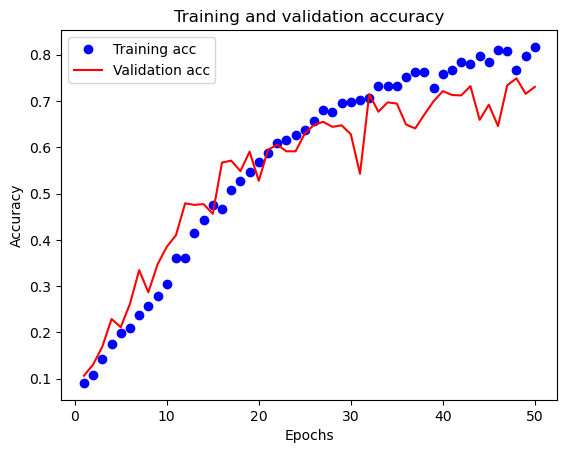

Text(0, 0.5, 'Loss')

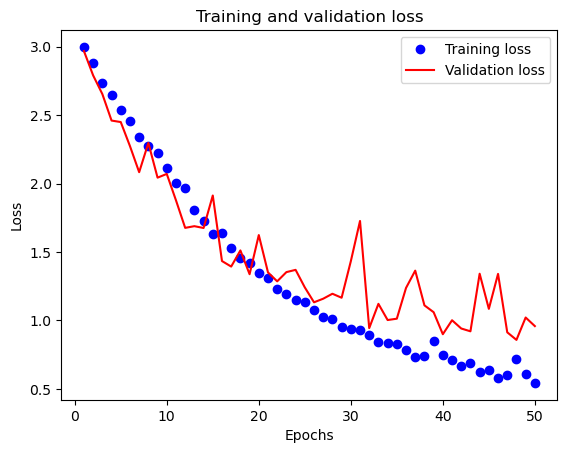

In [34]:
# Plotting training loss and accuracy as well as validation loss and accuracy over the number of epochs
hist_dict = hist.history

# obtain the accuracy and loss of the training set and verification set in the returned
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')  

In [35]:
model.evaluate(test_dataset, return_dict=True)

187/187 [==============================] - 25s 134ms/step - loss: 0.6051 - accuracy: 0.8160


{'loss': 0.6051117181777954, 'accuracy': 0.8160013556480408}

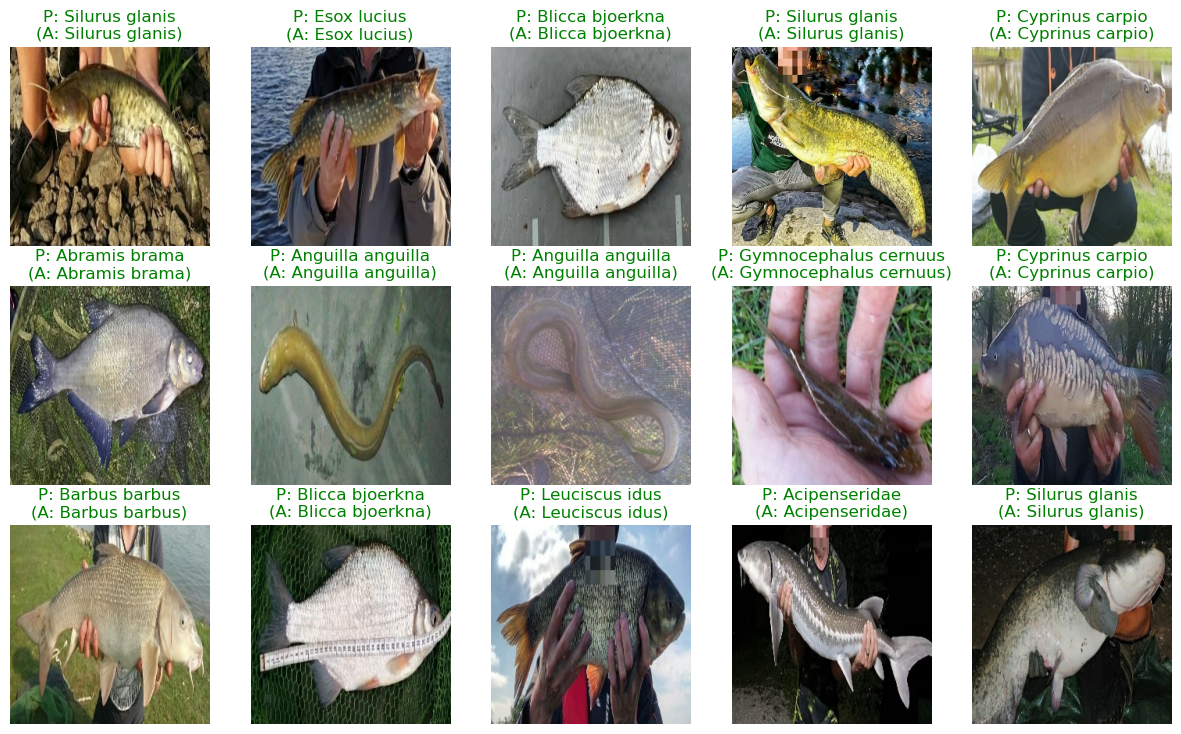

In [36]:
sample_predictions = model(sample_imgs)
# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i].astype("uint8"))
    #plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = sample_labels[i]# a_class = np.argmax(sample_labels[i]) ##np.argmax was the problem?!?
    #plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",# class_names[a_class]
    color=("green" if p_class == a_class else "red"))
    plt.axis("off")
plt.show()

### Backup code

ada = tf.keras.optimizers.Adam(learning_rate=0.0001)
def build_model():
      model = Sequential([
          norm_layer, 
          Conv2D(filters=64, kernel_size=(3,3), padding="same", input_shape=(image_size), activation= "relu"), 
          Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.5),
          Flatten(),
          Dense(512, activation='relu'),
          Dense(512, activation='relu'),# num_classes*25 = 500
          Dropout(0.5),
          Dense(num_classes, activation='softmax')#num_classes * 1.5 or 20 * 1. 
      ])
      model.compile(
          optimizer=ada,#'adam',#learning_rate=0.0004,or 3e-4
          loss='sparse_categorical_crossentropy',#sparse_categorical_crossentropy
          metrics=['accuracy']
          )
      return model 